# Cepheid Variable Analysis
### Sean Stroud

In [1]:
#Python package imports
import glob
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr, chisquare
from scipy.optimize import curve_fit
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Downloading Light Curves with Curl

In [2]:
biglist = np.loadtxt('Over60.txt', skiprows=1, delimiter=',',dtype=np.int64)
biglistIDs = biglist[:,0]
len(biglistIDs) == 700
biglist[-1]

array([6499632424888893824,                  61], dtype=int64)

In [3]:
#for i in range(0,len(biglistIDs)):
    #ID = str(biglistIDs[i])
    #url = "http://geadata.esac.esa.int/data-server/data?RETRIEVAL_TYPE=epoch_photometry&ID="+ID+"&FORMAT=CSV"
    #file = 'lc_'+ID+'.txt'
    #print('curl ' + '"' + url + '"' + ' > '+file)

In [4]:
###Retrieving properties of cataloged Cepheids from the public Gaia table "vari_cepheid".
job = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_cepheid order by source_id")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
lookup = 506602976101284736
r[np.argwhere(r['source_id']==lookup)]

solution_id [1],source_id [1],pf [1],pf_error [1],p1_o [1],p1_o_error [1],p2_o [1],p2_o_error [1],p3_o [1],p3_o_error [1],epoch_g [1],epoch_g_error [1],epoch_bp [1],epoch_bp_error [1],epoch_rp [1],epoch_rp_error [1],int_average_g [1],int_average_g_error [1],int_average_bp [1],int_average_bp_error [1],int_average_rp [1],int_average_rp_error [1],peak_to_peak_g [1],peak_to_peak_g_error [1],peak_to_peak_bp [1],peak_to_peak_bp_error [1],peak_to_peak_rp [1],peak_to_peak_rp_error [1],metallicity [1],metallicity_error [1],r21_g [1],r21_g_error [1],r31_g [1],r31_g_error [1],phi21_g [1],phi21_g_error [1],phi31_g [1],phi31_g_error [1],num_clean_epochs_g [1],num_clean_epochs_bp [1],num_clean_epochs_rp [1],g_absorption [1],g_absorption_error [1],type_best_classification [1],type2_best_sub_classification [1],mode_best_classification [1],multi_mode_best_classification [1]
,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,,,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object,object,object,object
369295549951641967,506602976101284736,5.604120183861134,5.728636213348905e-06,--,--,--,--,--,--,1689.1778837673512,8.101515026819673e-06,1689.127589491217,8.101515026819673e-06,1689.1896645547617,8.101515026819673e-06,13.191810946301487,7.135040283684458e-05,13.921274585124301,0.0002592852906130191,12.349574538627943,0.000154602754655739,0.6699360132240599,0.0003345247592397576,0.845890006765952,0.0016998087031785292,0.5484905159586759,0.0011527640670453052,-0.06745549918303873,0.23376233239533326,0.4274436154646133,0.0005302369382220296,0.2029593996227815,0.0003499862175484567,4.986322967228595,0.0012942007785473207,2.98811987452887,0.003042170224844588,74,74,72,--,--,DCEP,--,FUNDAMENTAL,--


## Histogram of Intesnity Averaged Magnitudes

In [6]:
def BigHist(lc_files):
    """
    
    Inputs: 
    'lc_files', downloaded text file of Gaia DR2 light curve data(String).
    
    Outputs: 
    Light curve figure in terms of flux.
    Light curve figure in terms of magnitude.
    """
    mags = []
    pers = []
    for i in range(0, len(lc_files)):
        source_id = np.loadtxt(lc_files[i],skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
        ceph_source = source_id[0]
        per_table = r['pf'][np.argwhere(r['source_id']==ceph_source)]
        per_table = per_table[0][0]
        if str(per_table) == '--':
            continue
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_source)]
        mag_table = mag_table[0][0]
        mags.append(mag_table)
        pers.append(per_table)
        #mags = np.concatenate([mags, mag_table])
        #print(str(i+1)+'/'+str(len(lc_files))+' Source = '+str(ceph_source))
    print(str(len(mags))+'/'+str(len(lc_files)))
    plt.figure(figsize=(6,4))
    plt.hist(mags, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Histogram of Gaia Cepheid Magnitudes (n>60)')
    plt.xlabel('Intensity-Averaged Magnitude (Published)')
    plt.ylabel('Count')
    #plt.savefig('hist_mags.png', bbox_inches='tight', dpi=300)
    plt.show()
    #Periods
    plt.figure(figsize=(6,4))
    plt.hist(pers, bins='auto', edgecolor='black', linewidth=1, color='r')
    plt.title('Histogram of Gaia Cepheid Periods (n>60)')
    plt.xlabel('Period of Fundamental Pulsation Mode [days]')
    plt.ylabel('Count')
    plt.xlim(0,42)
    #plt.savefig('hist_pers_cropped.png', bbox_inches='tight', dpi=300)
    plt.show()

16/16


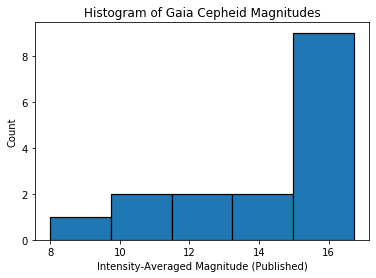

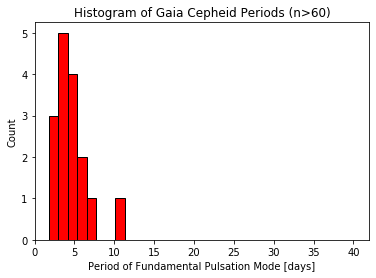

In [7]:
files = glob.glob('lc_*.txt')
BigHist(files)

In [8]:
def BiggerHist(lc_file):
    """
    
    Inputs: 
    'lc_file', downloaded text file of Gaia DR2 light curve data(String).
    
    Outputs: 
    Light curve figure in terms of flux.
    Light curve figure in terms of magnitude.
    """
    
    ###Important constants
    zp = 25.6883657251 #Gaia DR2 zero point
    c_mags = []
    c_fluxs = []
    wf_mags = []
    mean_fluxs = []
    mean_mags = []
    mag_tables = []
    gis_mags = []
    for i in range(0, len(lc_file)):
        source_id = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
        ceph_source = source_id[0]
        per_table = r['pf'][np.argwhere(r['source_id']==ceph_source)]
        per_table = per_table[0][0]
        if str(per_table) == '--':
            continue
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_source)]
        mag_table = mag_table[0][0]
        
        ###Retreving and sorting light curve properties from downloaded Gaia files
        lcs = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
        band = np.loadtxt(lc_file[i],skiprows=1,delimiter=',',usecols=2, dtype=np.str)
        time = lcs[:,0]
        mag = lcs[:,1]
        flux = lcs[:,2]
        flux_error = lcs[:,3]
        
        ###Seperating source properties by band
        G_ind = np.argwhere(band=='G')
        time_G = time[G_ind[0][0]:G_ind[-1][0]]
        mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
        flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
        flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]
        mag_error_G = (2.5/np.log(10))*flux_error_G/flux_G
        phase = time_G % per_table
    
        ###Create function we want to Fourier fit
        def SevDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,C):
            per = per_table
            deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
            deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
            deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
            deg4 = (np.sin(2*np.pi*4*x/per)*amp7) + (np.cos(2*np.pi*4*x/per)* amp8)
            deg5 = (np.sin(2*np.pi*5*x/per)*amp9) + (np.cos(2*np.pi*5*x/per)* amp10)
            deg6 = (np.sin(2*np.pi*6*x/per)*amp11) + (np.cos(2*np.pi*6*x/per)* amp12)
            deg7 = (np.sin(2*np.pi*7*x/per)*amp13) + (np.cos(2*np.pi*7*x/per)* amp14)
            return C + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        
        ###Generation of "first guesses" for our Fourier fit function for flux.
        guess_freq = 1
        guess_amp = 3*np.std(flux_G)/(2**0.5)
        guess_C = np.mean(flux_G)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
        
        ###Repeat for magnitude.
        guess_freq2 = 1
        guess_amp2 = 3*np.std(mag_G)/(2**0.5)
        guess_C2 = np.mean(mag_G)
        p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_C2]
        
        ###Now do the fits
        fit_flux = curve_fit(SevDegFit, phase, flux_G, p0=p0, sigma=flux_error_G, absolute_sigma=True)
        fit_mag = curve_fit(SevDegFit, phase, mag_G, p0=p02, sigma=mag_error_G, absolute_sigma=True)
        x = np.linspace(min(phase),max(phase),num=2**16)
        fitcurve_flux = SevDegFit(x, *fit_flux[0])
        fitcurve_mag = SevDegFit(x, *fit_mag[0])
        
        ###Weighted mean of Gaia magnitude points and fitted magnitude curve.
        distances = []
        weights = []
        chi2s = []
        for j in range(0, len(mag_G)):
            phase_value = phase[j]
            fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
            fit_ind = int(fit_ind)
            distance = mag_G[j] - fitcurve_mag[fit_ind]
            weight = 1/((np.abs(distance)+0.002)**2)
            chi2 = chisquare(f_obs=mag_G, f_exp=fitcurve_mag[fit_ind])
            distances.append(distance)
            weights.append(weight)
            chi2s.append(chi2)
        wf = np.average(flux_G, weights=weights)
        wf_mag = zp - 2.5*np.log10(wf)
        chi2_mean = np.mean(chi2s)
        
        #Stuff to print
        C_mag = fit_mag[0][-1]
        C_flux = fit_flux[0][-1]
        C_flux_conv = zp - 2.5*np.log10((C_flux))

        med = np.median(zp - 2.5*np.log10(flux_G))
        mea = zp - 2.5*np.log10(np.mean(flux_G))
        med2 = np.median(mag_G)
        mea2 = np.mean(mag_G)
       
        #Gisella int av mag
        gis_flux = 10**((zp - fitcurve_mag)/2.5)
        gis_flux_mean = np.mean(gis_flux)
        gis_mag = zp - 2.5*np.log10(gis_flux_mean)

        #print('C_mag             = '+str(C_mag))
        #print('C_flux            = '+str(C_flux_conv))
        #print('WF_mag            = '+str(wf_mag))
        #print('Mean_flux         = '+str(mea))
        #print('Mean_mag          = '+str(mea2))
        #print('int_avg_mag_DR2   = '+str(mag_table))
        #print('int_avg_mag_shown = '+str(gis_mag))
        
        c_mags.append(C_mag)
        c_fluxs.append(C_flux_conv)
        wf_mags.append(wf_mag)
        mean_fluxs.append(mea)
        mean_mags.append(mea2)
        mag_tables.append(mag_table)
        gis_mags.append(gis_mag)
    print(str(len(mag_tables))+'/'+str(len(lc_file)))
    #C_mag
    plt.figure(figsize=(6,4))
    plt.hist(c_mags, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Histogram of Gaia Cepheid Magnitudes')
    plt.xlabel('C Mag')
    plt.ylabel('Count')
    #plt.savefig('hist_mags6.png', bbox_inches='tight', dpi=300)
    plt.show()
    #C_flux_conv
    plt.figure(figsize=(6,4))
    plt.hist(c_fluxs, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Histogram of Gaia Cepheid Magnitudes')
    plt.xlabel('Converted C Flux')
    plt.ylabel('Count')
    #plt.savefig('hist_mags7.png', bbox_inches='tight', dpi=300)
    plt.show()
    #WF_mag
    plt.figure(figsize=(6,4))
    plt.hist(wf_mags, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Histogram of Gaia Cepheid Magnitudes')
    plt.xlabel('Weighted Mean Magnitude')
    plt.ylabel('Count')
    #plt.savefig('hist_mags3.png', bbox_inches='tight', dpi=300)
    plt.show()
    #Mean mag
    plt.figure(figsize=(6,4))
    plt.hist(mean_mags, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Histogram of Gaia Cepheid Magnitudes')
    plt.xlabel('Mean Magnitude')
    plt.ylabel('Count')
    #plt.savefig('hist_mags4.png', bbox_inches='tight', dpi=300)
    plt.show()
    #Mean converted flux
    plt.figure(figsize=(6,4))
    plt.hist(mean_fluxs, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Histogram of Gaia Cepheid Magnitudes')
    plt.xlabel('Converted Mean Flux')
    plt.ylabel('Count')
    #plt.savefig('hist_mags5.png', bbox_inches='tight', dpi=300)
    plt.show()
    #int av mag published
    plt.figure(figsize=(6,4))
    plt.hist(mag_tables, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Histogram of Gaia Cepheid Magnitudes')
    plt.xlabel('Intensity-Averaged Magnitude (Published)')
    plt.ylabel('Count')
    #plt.savefig('hist_mags1.png', bbox_inches='tight', dpi=300)
    plt.show()
    #int av mag calculated
    plt.figure(figsize=(6,4))
    plt.hist(gis_mags, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Histogram of Gaia Cepheid Magnitudes')
    plt.xlabel('Intensity-Averaged Magnitude (Calculated)')
    plt.ylabel('Count')
    plt.savefig('hist_mags2.png', bbox_inches='tight', dpi=300)
    plt.show()

In [9]:
files = glob.glob('lc_*.txt')
#BiggerHist(files)

In [10]:
testy = np.array([2,4,16,65536])
testy = np.delete(testy,2)
testy

array([    2,     4, 65536])

## Light Curver

In [112]:
def LightCurver(lc_file):
    """
    
    Inputs: 
    'lc_file', a downloaded text file of Gaia DR2 light curve data for one star (String).
    
    Outputs: 
    Light curve figure in terms of flux.
    Light curve figure in terms of magnitude.
    """
    
    ###Important constants
    zp = 25.6883657251 #Gaia DR2 zero point
    
    #for i in range(0, len(ceph_sources)):
    source_id = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    ceph_source = source_id[0]
    per_table = r['pf'][np.argwhere(r['source_id']==ceph_source)]
    per_table = per_table[0][0]
    mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_source)]
    mag_table = mag_table[0][0]
        
    ###Retreving and sorting light curve properties from downloaded Gaia files
    lcs = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    band = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3]
        
    ###Seperating source properties by band
    G_ind = np.argwhere(band=='G')
    time_G = time[G_ind[0][0]:G_ind[-1][0]]
    mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
    flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
    flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]
    mag_error_G = (2.5/np.log(10))*flux_error_G/flux_G
    phase = time_G % per_table
    #print(flux_error_G)
    #print(max(flux_error_G))
    
    ###Removing outliers
    #norm = np.abs((flux_error_G - np.mean(flux_error_G))/iqr(flux_error_G))
    #for j in range(0,len(norm)):
        #if norm[j] > 5:
            #norm_new = np.delete(norm,j) #Must delete at correct index of original array.
    
    ###Create function we want to Fourier fit
    def OneDegFit(x,per,amp1,amp2,C):
        per = per_table
        deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
        return C + deg1

    def ThreeDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,C):
        per = per_table
        deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
        deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
        deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
        return C + deg1 + deg2 + deg3
    
    def FiveDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,C):
        per = per_table
        deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
        deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
        deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
        deg4 = (np.sin(2*np.pi*4*x/per)*amp7) + (np.cos(2*np.pi*4*x/per)* amp8)
        deg5 = (np.sin(2*np.pi*5*x/per)*amp9) + (np.cos(2*np.pi*5*x/per)* amp10)
        return C + deg1 + deg2 + deg3 + deg4 + deg5
    
    def SevDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,C):
        per = per_table
        deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
        deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
        deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
        deg4 = (np.sin(2*np.pi*4*x/per)*amp7) + (np.cos(2*np.pi*4*x/per)* amp8)
        deg5 = (np.sin(2*np.pi*5*x/per)*amp9) + (np.cos(2*np.pi*5*x/per)* amp10)
        deg6 = (np.sin(2*np.pi*6*x/per)*amp11) + (np.cos(2*np.pi*6*x/per)* amp12)
        deg7 = (np.sin(2*np.pi*7*x/per)*amp13) + (np.cos(2*np.pi*7*x/per)* amp14)
        return C + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        
    ###Generation of "first guesses" for our Fourier fit function for flux.
    guess_freq = 1
    guess_amp = 3*np.std(flux_G)/(2**0.5)
    guess_C = np.mean(flux_G)
    p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
    p0_1=[guess_freq,guess_amp,guess_amp,guess_C]
    p0_3=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
    p0_5=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
    
    ###Repeat for magnitude.
    guess_freq2 = 1
    guess_amp2 = 3*np.std(mag_G)/(2**0.5)
    guess_C2 = np.mean(mag_G)
    p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_C2]
        
    ###Now do the fits
    fit_flux = curve_fit(SevDegFit, phase, flux_G, p0=p0, sigma=flux_error_G, absolute_sigma=True)
    fit_mag = curve_fit(SevDegFit, phase, mag_G, p0=p02, sigma=mag_error_G, absolute_sigma=True)
    x = np.linspace(min(phase),max(phase),num=2**16)
    fitcurve_flux = SevDegFit(x, *fit_flux[0])
    fitcurve_mag = SevDegFit(x, *fit_mag[0])
    
    fit_flux1 = curve_fit(OneDegFit, phase, flux_G, p0=p0_1)
    fit_flux3 = curve_fit(ThreeDegFit, phase, flux_G, p0=p0_3)
    fit_flux5 = curve_fit(FiveDegFit, phase, flux_G, p0=p0_5)
    fitcurve_flux1 = OneDegFit(x, *fit_flux1[0])
    fitcurve_flux3 = ThreeDegFit(x, *fit_flux3[0])
    fitcurve_flux5 = FiveDegFit(x, *fit_flux5[0])
    
    #print(p0)
    #print(fit_flux[0])
    #print(fitcurve_flux)
    
    ###Weighted mean of Gaia magnitude points and fitted magnitude curve.
    distances = []
    weights = []
    chi2s = []
    for j in range(0, len(mag_G)):
        phase_value = phase[j]
        fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
        fit_ind = int(fit_ind)
        distance = mag_G[j] - fitcurve_mag[fit_ind]
        weight = 1/((np.abs(distance)+0.002)**2)
        chi2 = chisquare(f_obs=mag_G, f_exp=fitcurve_mag[fit_ind])
        distances.append(distance)
        weights.append(weight)
        chi2s.append(chi2)
    wf = np.average(flux_G, weights=weights)
    wf_mag = zp - 2.5*np.log10(wf)
    chi2_mean = np.mean(chi2s)
    
    #Plotting flux
    plt.figure(figsize=(8,4)) 
    
    plt.errorbar(phase/per_table, flux_G/100, yerr=flux_error_G/100, ls='None', ecolor='k', capsize=2)
    plt.scatter(phase/per_table, flux_G/100, c='g')
    
    #plt.plot(x/per_table, fitcurve_flux1, c='orange', label='N = 1')
    #plt.plot(x/per_table, fitcurve_flux3, c='purple', label='N = 3')
    #plt.plot(x/per_table, fitcurve_flux5, c='blue', label='N = 5')
    plt.plot(x/per_table, fitcurve_flux/100, c='k', label='N = 7')
    #plt.legend(loc=(0.2,0.5), fontsize='large')
    
    plt.xlim(0,1)
    plt.ylim(min(flux_G)/100,max(flux_G)/100)
             
    plt.title('Light Curve for ' + str(ceph_source) +'  |  Per = '+ str('%.3f'%per_table))
    plt.xlabel('Phase')
    plt.ylabel('G-band Flux [e-/s] / 100')
    plt.savefig('LCfit_'+str(ceph_source)+'_flux.png', bbox_inches='tight', dpi=150)
    #plt.savefig('LCfit_'+str(ceph_source)+'_degrees.png', bbox_inches='tight', dpi=300)
    plt.show()
        
    #Plotting mag
    plt.figure(figsize=(8,4)) 
    plt.errorbar(phase/per_table, mag_G, yerr=mag_error_G, ls='None', ecolor='k', capsize=2)
    plt.scatter(phase/per_table, mag_G, c='cyan')
    plt.plot(x/per_table, fitcurve_mag, c='k')
    
    plt.xlim(0,1)
    plt.ylim(min(mag_G),max(mag_G))
    
    plt.title('Light Curve for ' + str(ceph_source) +'  |  Per = '+ str('%.3f'%per_table))
    plt.xlabel('Phase')
    plt.ylabel('Vega Magnitude [mag]')
    plt.gca().invert_yaxis()
    plt.savefig('LCfit_'+str(ceph_source)+'_mag.png', bbox_inches='tight', dpi=150)
    plt.show()
        
    #Stuff to print
    C_mag = fit_mag[0][-1]
    C_flux = fit_flux[0][-1]
    C_flux_conv = zp - 2.5*np.log10((C_flux))

    med = np.median(zp - 2.5*np.log10(flux_G))
    mea = zp - 2.5*np.log10(np.mean(flux_G))
    med2 = np.median(mag_G)
    mea2 = np.mean(mag_G)
       
    #Gisella int av mag
    gis_flux = 10**((zp - fitcurve_mag)/2.5)
    gis_flux_mean = np.mean(gis_flux)
    gis_mag = zp - 2.5*np.log10(gis_flux_mean)
    
    #print('chisquare         = '+str(chi2_mean))
    #print('C_mag             = '+str(C_mag))
    #print('C_flux            = '+str(C_flux_conv))
    #print('WF_mag            = '+str(wf_mag))
    #print('Mean_flux         = '+str(mea))
    #print('Mean_mag          = '+str(mea2))
    #print('int_avg_mag_DR2   = '+str(mag_table))
    #print('int_avg_mag_shown = '+str(gis_mag))

In [ ]:
test60 = 6499632424888893824
test60f = 'lc_'+str(test60)+'.txt'
#LightCurver(test60f)
#per_table = r['pf'][np.argwhere(r['source_id']==test60)]
#per_table

Key takeaway: Not every Gaia Cepheid has a published fundametal period, some only have overtones. 

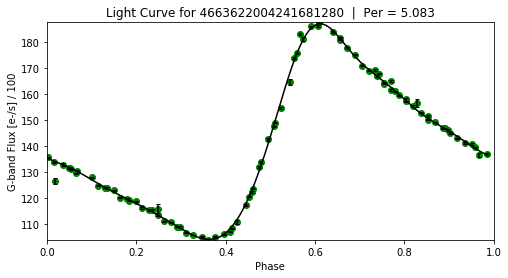

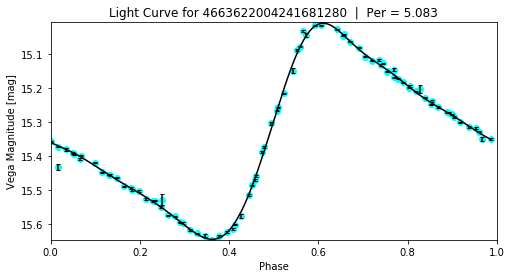

In [113]:
lc_files = glob.glob('lc_*.txt')
for i in range(0, len(lc_files)):
    source_id = np.loadtxt(lc_files[i],skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    ceph_source = source_id[0]
    if ceph_source != 4663622004241681280:
        continue
    #per_table = r['pf'][np.argwhere(r['source_id']==ceph_source)]
    #per_table = per_table[0][0]
    #if str(per_table) == '--':
        #continue
    LightCurver(lc_files[i])

## Two Input Light Curver

In [ ]:
def LightCurver_bad(ceph_list, lc_file):
    """
    
    Inputs: 
    'ceph_list', a list Gaia source IDs for the desired Cepheids to analyze (String).
    'lc_file', a downloaded text file of Gaia DR2 light curve data (String).
    The pipeline will search if a given Cepheid in 'ceph_list' exists in 'lc_file'. 
    
    Outputs: 
    Light curve figure in terms of flux.
    Light curve figure in terms of magnitude.
    """
    
    ###Retrieving list of desired Cepheids to analyze
    ceph_sources = np.loadtxt(ceph_list, dtype=np.int64)
    
    ###Retrieving properties of cataloged Cepheids from the public Gaia table "vari_cepheid".
    #job = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_cepheid order by source_id")
    #r = job.get_results()
    
 

    ###Important constants
    zp = 25.6883657251 #Gaia DR2 zero point
    
    for i in range(0, len(ceph_sources)):
        ###If we wish to only look at one particular Cepheid, we may uncomment the following two lines.
        if ceph_sources[i] != 2972082493697861504:
            continue
        per_table = r['pf'][np.argwhere(r['source_id']==ceph_sources[i])]
        per_table = per_table[0][0]
        if str(per_table) == '--':
            continue
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_sources[i])]
        mag_table = mag_table[0][0]
        
        ###Retreving and sorting light curve properties from downloaded Gaia files
        lcs = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
        source_id = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
        ind = np.argwhere(source_id==ceph_sources[i])
        if len(ind) == 0:
            continue
        band = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
        time = lcs[:,0]
        mag = lcs[:,1]
        flux = lcs[:,2]
        flux_error = lcs[:,3]
        
        ###Seperating properties for each source
        mag = mag[ind[0][0]:ind[-1][0]]
        time = time[ind[0][0]:ind[-1][0]]
        print('---')
        #print(ceph_sources[i])
        #print(time)
        flux = flux[ind[0][0]:ind[-1][0]]
        band = band[ind[0][0]:ind[-1][0]]
        flux_error = flux_error[[0][0]:ind[-1][0]]
        print(flux_error)
        print(max(flux_error))
        
        ###Seperating source properties by band
        G_ind = np.argwhere(band=='G')
        time_G = time[G_ind[0][0]:G_ind[-1][0]]
        mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
        flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
        flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]
        mag_error_G = (2.5/np.log(10))*flux_error_G/flux_G
        phase = time_G % per_table
        print(flux_error_G)
        print(max(flux_error_G))
        
        ###Create function we want to Fourier fit
        def SevDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,C):
            per = per_table
            deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
            deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
            deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
            deg4 = (np.sin(2*np.pi*4*x/per)*amp7) + (np.cos(2*np.pi*4*x/per)* amp8)
            deg5 = (np.sin(2*np.pi*5*x/per)*amp9) + (np.cos(2*np.pi*5*x/per)* amp10)
            deg6 = (np.sin(2*np.pi*6*x/per)*amp11) + (np.cos(2*np.pi*6*x/per)* amp12)
            deg7 = (np.sin(2*np.pi*7*x/per)*amp13) + (np.cos(2*np.pi*7*x/per)* amp14)
            return C + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        
        ###Generation of "first guesses" for our Fourier fit function for flux.
        guess_freq = 1
        guess_amp = 3*np.std(flux_G)/(2**0.5)
        guess_C = np.mean(flux_G)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
        
        ###Repeat for magnitude.
        guess_freq2 = 1
        guess_amp2 = 3*np.std(mag_G)/(2**0.5)
        guess_C2 = np.mean(mag_G)
        p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_C2]
        
        ###Now do the fits
        fit_flux = curve_fit(SevDegFit, phase, flux_G, p0=p0, sigma=flux_error_G, absolute_sigma=True)
        fit_mag = curve_fit(SevDegFit, phase, mag_G, p0=p02, sigma=mag_error_G, absolute_sigma=True)
        x = np.linspace(min(phase),max(phase),num=2**16)
        fitcurve_flux = SevDegFit(x, *fit_flux[0])
        fitcurve_mag = SevDegFit(x, *fit_mag[0])
        
        ###Weighted mean of Gaia magnitude points and fitted magnitude curve.
        distances = []
        weights = []
        for j in range(0, len(mag_G)):
            phase_value = phase[j]
            fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
            fit_ind = int(fit_ind)
            distance = mag_G[j] - fitcurve_mag[fit_ind]
            weight = 1/((np.abs(distance)+0.002)**2)
            distances.append(distance)
            weights.append(weight)
        wf = np.average(flux_G, weights=weights)
        wf_mag = zp - 2.5*np.log10(wf)
        
        #Plotting flux
        plt.plot(x, fitcurve_flux, c='r')
        plt.errorbar(phase, flux_G, yerr=flux_error_G, ls='None', ecolor='k', capsize=2)
        plt.scatter(phase, flux_G, c='g')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per_table))
        plt.xlabel('Phase')
        plt.ylabel('G Band Flux')
        #plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_flux_sigma.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        #Plotting mag
        plt.errorbar(phase, mag_G, yerr=mag_error_G, ls='None', ecolor='green', capsize=2)
        plt.scatter(phase, mag_G, c='b')
        plt.plot(x, fitcurve_mag, c='r')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per_table))
        plt.xlabel('Phase')
        plt.ylabel('Vega Magnitude')
        plt.gca().invert_yaxis()
        #plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_mag.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        #Stuff to print
        C_mag = fit_mag[0][-1]
        C_flux = fit_flux[0][-1]
        C_flux_conv = zp - 2.5*np.log10((C_flux))

        med = np.median(zp - 2.5*np.log10(flux_G))
        mea = zp - 2.5*np.log10(np.mean(flux_G))
        med2 = np.median(mag_G)
        mea2 = np.mean(mag_G)
        
        #Gisella int av mag
        gis_flux = 10**((zp - fitcurve_mag)/2.5)
        gis_flux_mean = np.mean(gis_flux)
        gis_mag = zp - 2.5*np.log10(gis_flux_mean)

        print('C_mag             = '+str(C_mag))
        print('C_flux            = '+str(C_flux_conv))
        print('WF_mag            = '+str(wf_mag))
        #print('Median_flux      = '+str(med))
        print('Mean_flux         = '+str(mea))
        #print('Median_mag       = '+str(med2))
        print('Mean_mag          = '+str(mea2))
        print('int_avg_mag_DR2   = '+str(mag_table))
        print('int_avg_mag_shown = '+str(gis_mag))

In [ ]:
sources = 'vari_cepheids_long2.txt'
lcs = 'lcs_3044.txt'
#LightCurver(sources, lcs)

In [ ]:
lc_files = glob.glob('lcs_*.txt')
#for i in range(0, len(lc_files)):
    #LightCurver_bad(sources, lc_files[i])

In [ ]:
#job2 = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_time_series_statistics order by source_id")
#res = job2.get_results()

In [ ]:
#np.set_printoptions(threshold=np.inf)
#source_IDs = np.array(res['source_id'])
#num_selected = np.array(res['num_selected_g_fov'])
#print(np.sort(num_selected))